## Example 05 - Defining a basic simulation on a real graph

### Imports
Import the required libraries

In [1]:
import opentnsim
print('This notebook has been tested with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook has been tested with OpenTNSim version 1.0.0


In [2]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSIM
import opentnsim.core as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = "Shape-Files/Rotterdam-Antwerpen-corridor"
name_graph = "edges_2.shp"

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

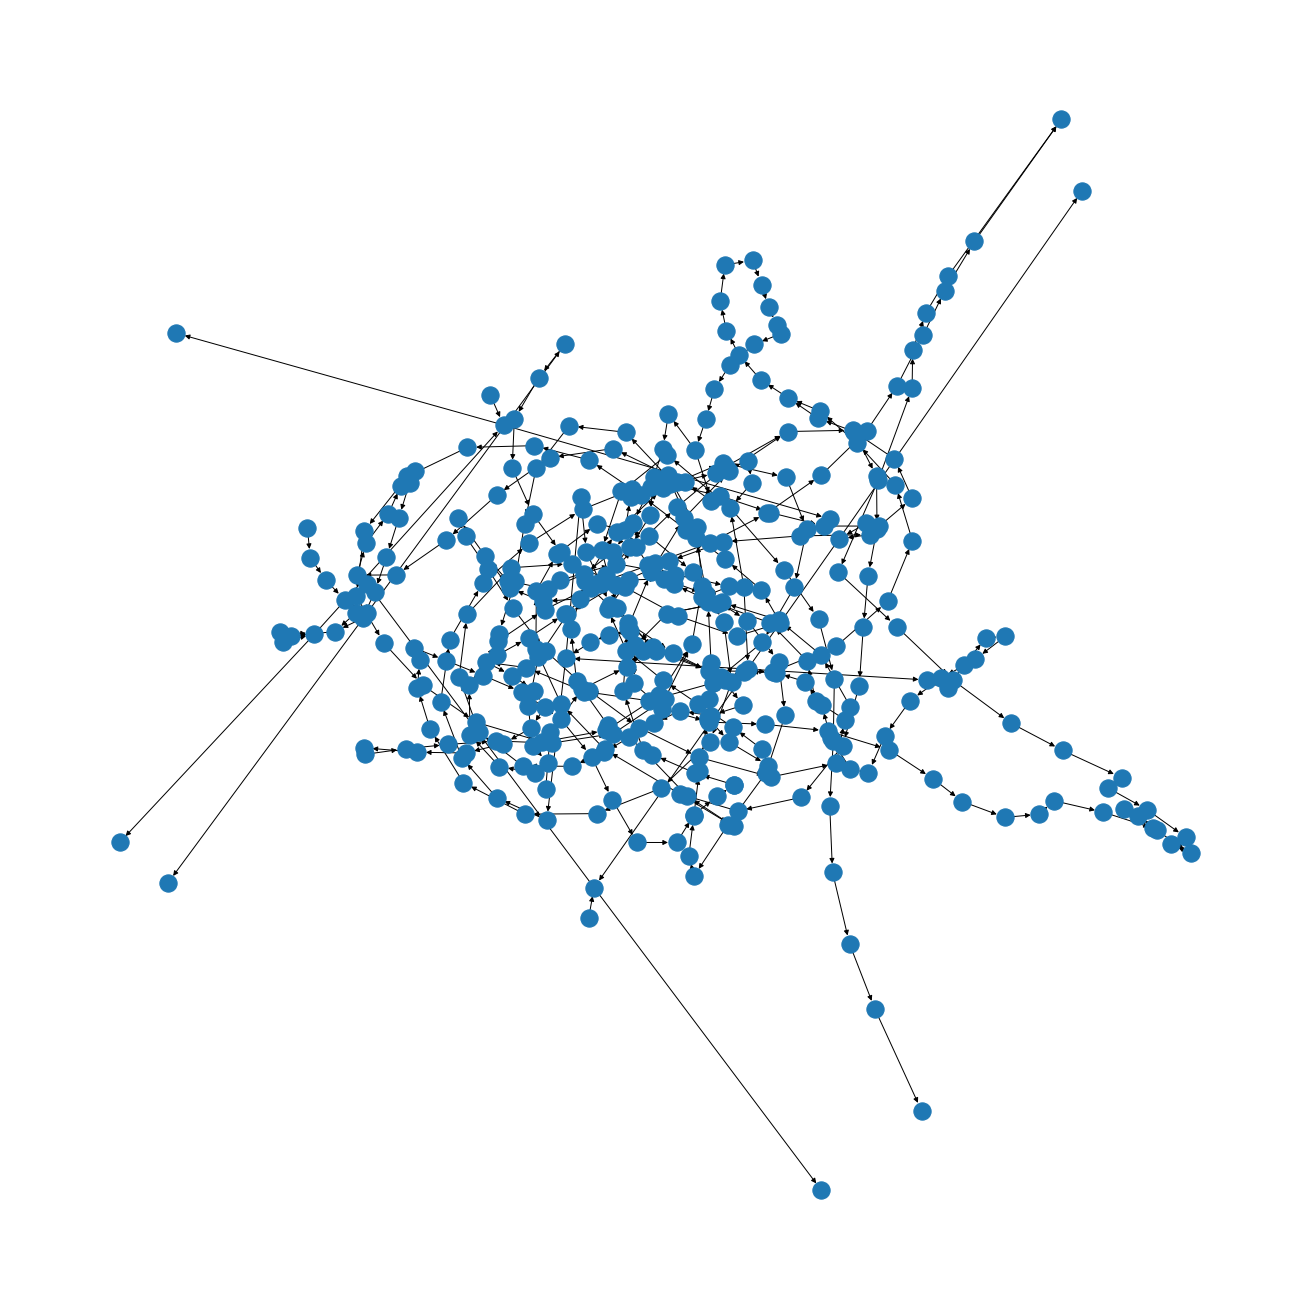

In [3]:
# Read the shape-file
FG = nx.read_shp(os.path.join(location_graph, name_graph), 
                 simplify=True)

# Draw the shape-file to get a first impression
plt.figure(figsize=(18,18))
nx.draw(FG)

# Show the drawing
plt.show()

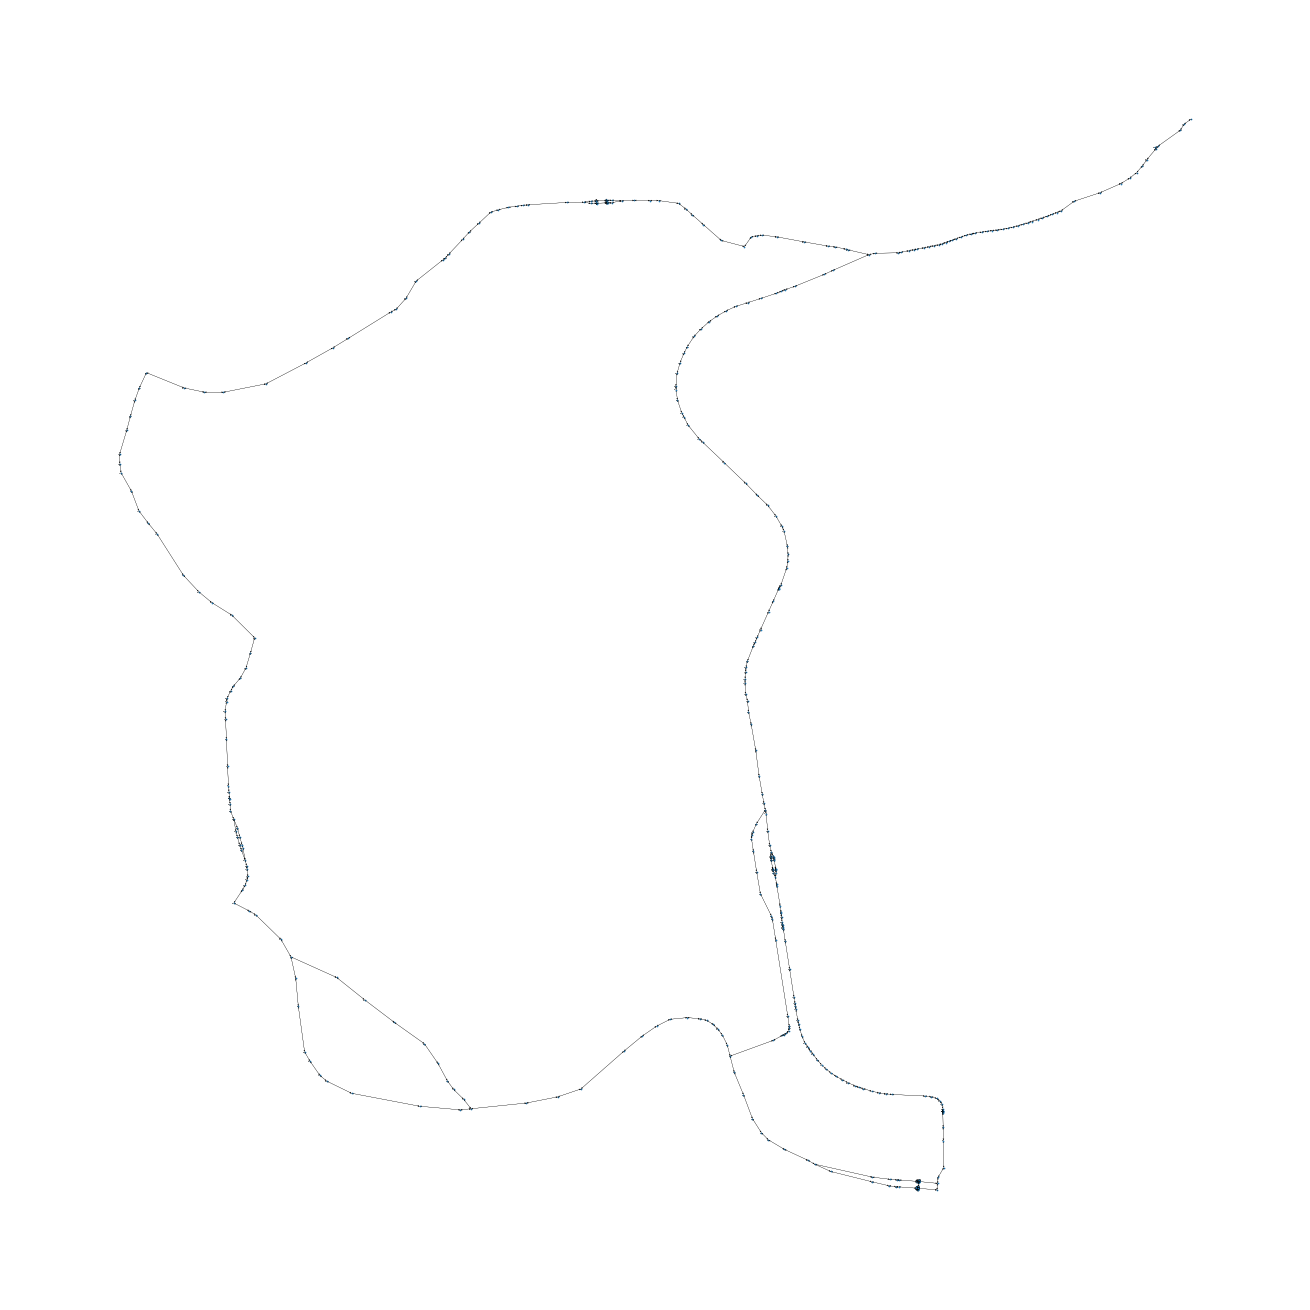

In [4]:
# calculate distance between two points
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                         shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2]
    
    return distance

H_G = nx.Graph()

lat_lon_to_index = {}
edge_id_counter = 0

for i, node in enumerate(FG.nodes(data = True)):
    H_G.add_node(i, pos = node[0], 
                    name = "Node {}".format(i),
                    geometry = shapely.geometry.Point(node[0][0], node[0][1]))
    lat_lon_to_index[node[0]] = i

    
for edge in FG.edges(data=True): 
    H_G.add_edge(lat_lon_to_index[edge[0]], 
                 lat_lon_to_index[edge[1]],
                 dis= calculate_distance(nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[1]]], 
                                         nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[0]]]))

FG = H_G.to_directed()
plt.figure(figsize=(18,18))
nx.draw(FG, nx.get_node_attributes(FG, 'pos'), with_labels=True, node_size=0.5, font_size = 2, width = 0.2, arrowsize = 3)
plt.show()

### Create vessels
Vessel without graph, but with shortest path.

In [5]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

### Define paths

In [6]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_1 = nx.dijkstra_path(FG, random_1, random_2)
print(path_1)

[203, 202, 408, 407, 299, 298, 297, 293, 292, 291, 355, 177, 176, 175, 212, 211, 8, 7, 6, 375, 5, 4, 3, 22, 21, 189, 361, 360, 149, 148, 147, 151, 188, 187, 385, 384, 142, 93, 92, 91, 186, 185, 283, 284, 359, 18, 19, 20, 239, 150, 85, 86, 87, 257, 344, 282, 256, 145, 143, 144, 313, 88, 89, 90, 109, 287, 288, 289, 345, 152, 75, 15, 16, 17, 388, 244, 245, 110, 111, 112, 146, 157, 227, 228, 50, 51]


In [7]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_2 = nx.dijkstra_path(FG, random_1, random_2)
print(path_2)

[217, 216, 156, 155, 154, 394, 184, 182, 183, 258, 259, 283, 284, 359, 18, 19, 20, 239, 150, 85, 86, 87, 257, 344, 282, 256, 145, 143, 144, 313, 88, 89, 90, 109, 287, 288, 289, 345, 152, 75, 15, 16, 17, 388, 244, 245, 193, 194, 195, 32, 33, 34, 246, 247, 52, 130, 131, 352, 305, 306, 307, 373, 353, 354, 277, 278, 279, 220, 221, 222, 273, 274, 103, 104, 105, 224, 63, 64, 65, 356, 340, 341, 342, 308, 309, 161, 162, 163, 325, 236, 235, 234, 167, 166, 165, 118]


In [8]:
paths = [path_1, path_2]

### Run simulation

In [9]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [10]:
for path in enumerate(paths):
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())
    
    # Add graph to environment
    env.FG = FG
    
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = path[1]

    # Start the simulation
    env.process(start(env, vessel))
    env.run()

    print("Simulation of path {} took {} seconds".format(path[0] + 1, int(env.now)))

Origin POINT (0 0)
Destination POINT (4.1902471 51.6021057)
Simulation of path 1 took 1594717775 seconds
Origin POINT (4.033314 51.4113788)
Destination POINT (4.2302951 51.446224)
Simulation of path 2 took 1589002683 seconds


### Testing
With v = 1 the distance of a path should be equal to the simulation time.

If simulation time == distance of path, test succeeds.

In [11]:
for geo in vessel.log["Geometry"]:
    print(geo.x, geo.y)

0.0 0.0
4.1902471 51.6021057
4.1902471 51.6021057
4.1903612 51.6010156
4.1903612 51.6010156
4.1908755 51.5976535
4.1908755 51.5976535
4.1926675 51.5934993
4.1926675 51.5934993
4.1936547 51.5920753
4.1936547 51.5920753
4.1952688 51.58955
4.1952688 51.58955
4.1998547 51.5851288
4.1998547 51.5851288
4.2013047 51.5840642
4.2013047 51.5840642
4.21016 51.5774798
4.21016 51.5774798
4.2190502 51.5707988
4.2190502 51.5707988
4.2238825 51.5669267
4.2238825 51.5669267
4.2281377 51.5637077
4.2281377 51.5637077
4.2314982 51.5603292
4.2314982 51.5603292
4.2340047 51.5569484
4.2340047 51.5569484
4.2348832 51.5555264
4.2348832 51.5555264
4.2363039 51.5504794
4.2363039 51.5504794
4.2365542 51.5478885
4.2365542 51.5478885
4.2364586 51.5457498
4.2364586 51.5457498
4.2359493 51.543441
4.2359493 51.543441
4.2335724 51.5380095
4.2335724 51.5380095
4.2327934 51.537021
4.2327934 51.537021
4.2327375 51.5369264
4.2327375 51.5369264
4.2326835 51.5368375
4.2326835 51.5368375
4.2304 51.5328
4.2304 51.5328
4.228499

In [12]:
vessel.log["Timestamp"]

[datetime.datetime(2020, 5, 8, 14, 31, 8),
 datetime.datetime(2020, 7, 13, 22, 55, 18, 900368),
 datetime.datetime(2020, 7, 13, 22, 55, 18, 900368),
 datetime.datetime(2020, 7, 13, 22, 57, 20, 442020),
 datetime.datetime(2020, 7, 13, 22, 57, 20, 442020),
 datetime.datetime(2020, 7, 13, 23, 3, 36, 201935),
 datetime.datetime(2020, 7, 13, 23, 3, 36, 201935),
 datetime.datetime(2020, 7, 13, 23, 11, 34, 787359),
 datetime.datetime(2020, 7, 13, 23, 11, 34, 787359),
 datetime.datetime(2020, 7, 13, 23, 14, 27, 360485),
 datetime.datetime(2020, 7, 13, 23, 14, 27, 360485),
 datetime.datetime(2020, 7, 13, 23, 19, 29, 773345),
 datetime.datetime(2020, 7, 13, 23, 19, 29, 773345),
 datetime.datetime(2020, 7, 13, 23, 29, 15, 424462),
 datetime.datetime(2020, 7, 13, 23, 29, 15, 424462),
 datetime.datetime(2020, 7, 13, 23, 31, 50, 763909),
 datetime.datetime(2020, 7, 13, 23, 31, 50, 763909),
 datetime.datetime(2020, 7, 13, 23, 47, 46, 511777),
 datetime.datetime(2020, 7, 13, 23, 47, 46, 511777),
 date

In [13]:
wgs84 = pyproj.Geod(ellps='WGS84')
distance_path_1 = 0
distance_path_2 = 0

for node in enumerate(path_1):
    orig = nx.get_node_attributes(FG, "geometry")[path_1[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_1[node[0] + 1]]

    distance_path_1 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_1):
                break

for node in enumerate(path_2):
    orig = nx.get_node_attributes(FG, "geometry")[path_2[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_2[node[0] + 1]]

    distance_path_2 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_2):
                break

In [14]:
distance_path_1, distance_path_2

(44017, 47331)